<a href="https://colab.research.google.com/github/Ahmed-cherif/Violence_app_detector/blob/main/DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

with open('text2.txt', 'r') as f:
  text = f.read()

sentences = text.split('\n')

data = []
result = []

for sentence in sentences:


  data.append(sentence)
  result.append("non violence médicale")

df = pd.DataFrame({"data": data, "resultat": result})

df.to_excel("output2.xlsx", index=False)

In [ ]:
import pandas as pd

# Lire le fichier Excel
df = pd.read_excel("output1.xlsx")

# Supprimer les lignes vides dans la colonne "data"
df = df[~df["data"].isnull()]

# Réécrire le dataframe dans le fichier Excel
df.to_excel("output1.xlsx", index=False)

Epoch 1/15
49/49 [==============================] - 7s 100ms/step - loss: 0.5408 - accuracy: 0.7079 - val_loss: 0.2633 - val_accuracy: 0.9056
Epoch 2/15
49/49 [==============================] - 2s 47ms/step - loss: 0.0900 - accuracy: 0.9694 - val_loss: 0.0514 - val_accuracy: 0.9872
Epoch 3/15
49/49 [==============================] - 2s 40ms/step - loss: 0.0170 - accuracy: 0.9968 - val_loss: 0.0684 - val_accuracy: 0.9821
Epoch 4/15
49/49 [==============================] - 1s 28ms/step - loss: 0.0102 - accuracy: 0.9968 - val_loss: 0.0282 - val_accuracy: 0.9898
Epoch 5/15
49/49 [==============================] - 1s 12ms/step - loss: 0.0079 - accuracy: 0.9987 - val_loss: 0.0216 - val_accuracy: 0.9898
Epoch 6/15
49/49 [==============================] - 1s 11ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0273 - val_accuracy: 0.9898
Epoch 7/15
49/49 [==============================] - 1s 15ms/step - loss: 0.0039 - accuracy: 0.9994 - val_loss: 0.0332 - val_accuracy: 0.9872
Epoch 8/15
8

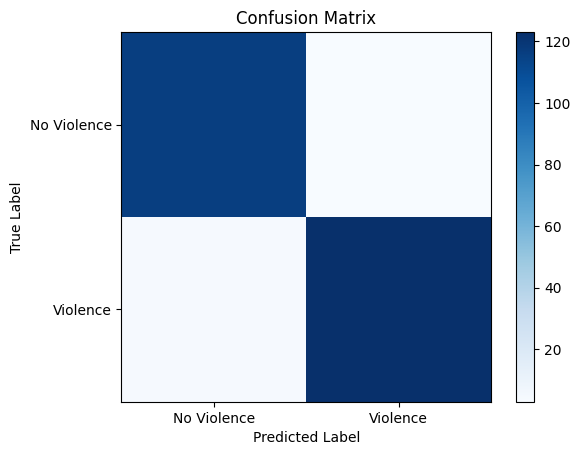

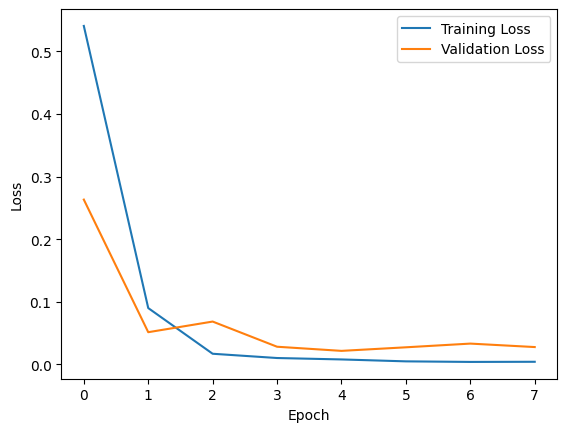

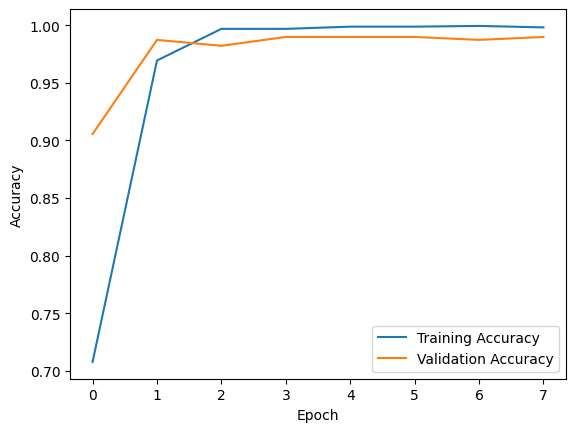

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if np.random.uniform(0, 1) > p]

augmented_train_sequences = [random_deletion(sequence) for sequence in train_sequences]
augmented_train_sequences = pad_sequences(augmented_train_sequences, maxlen=max_length)

# Combine original and augmented data
train_sequences = np.concatenate((train_sequences, augmented_train_sequences), axis=0)
train_labels = np.concatenate((train_labels, train_labels), axis=0)

# Hyperparameters for fine-tuning
batch_size = 32
epochs = 15

# Create and train the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model with callbacks
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model
best_model = load_model("best_model.h5")

# Evaluate the model on the test data
test_predictions = best_model.predict(test_sequences)
test_predictions = np.round(test_predictions).flatten()

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
test_roc_auc = roc_auc_score(test_labels, test_predictions)

# Display the results
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the best model
best_model.save("sentiment_model.h5")


Epoch 1/8
49/49 [==============================] - 8s 110ms/step - loss: 0.4842 - accuracy: 0.7768 - val_loss: 0.1708 - val_accuracy: 0.9388
Epoch 2/8
49/49 [==============================] - 3s 54ms/step - loss: 0.0704 - accuracy: 0.9821 - val_loss: 0.0335 - val_accuracy: 0.9949
Epoch 3/8
49/49 [==============================] - 1s 21ms/step - loss: 0.0248 - accuracy: 0.9936 - val_loss: 0.0843 - val_accuracy: 0.9923
Epoch 4/8
49/49 [==============================] - 1s 18ms/step - loss: 0.0139 - accuracy: 0.9987 - val_loss: 0.0162 - val_accuracy: 0.9974
Epoch 5/8
49/49 [==============================] - 1s 15ms/step - loss: 0.0060 - accuracy: 0.9987 - val_loss: 0.0128 - val_accuracy: 0.9974
Epoch 6/8
49/49 [==============================] - 1s 18ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0159 - val_accuracy: 0.9949
Epoch 7/8
49/49 [==============================] - 1s 12ms/step - loss: 0.0033 - accuracy: 0.9994 - val_loss: 0.0083 - val_accuracy: 0.9974
Epoch 8/8
8/8 [====

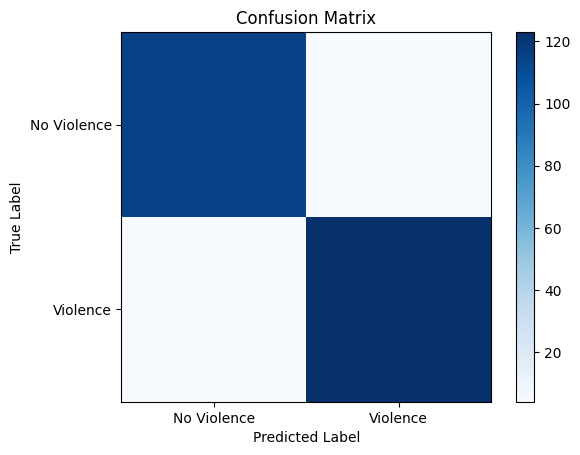

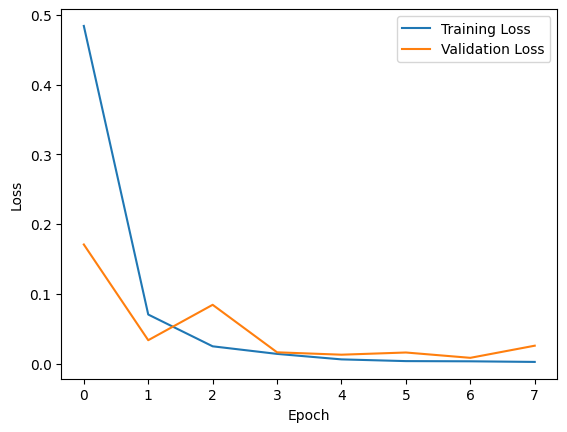

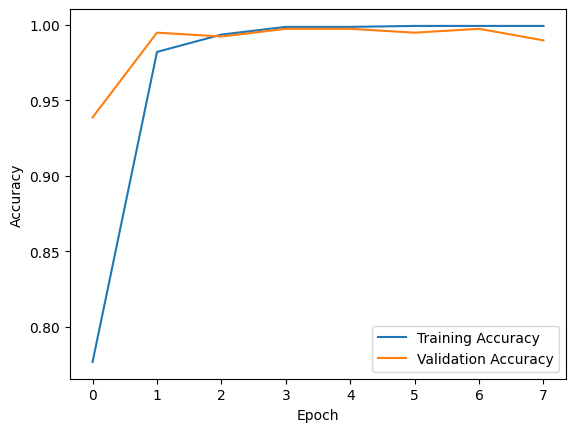

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if np.random.uniform(0, 1) > p]

augmented_train_sequences = [random_deletion(sequence) for sequence in train_sequences]
augmented_train_sequences = pad_sequences(augmented_train_sequences, maxlen=max_length)

# Combine original and augmented data
train_sequences = np.concatenate((train_sequences, augmented_train_sequences), axis=0)
train_labels = np.concatenate((train_labels, train_labels), axis=0)

# Hyperparameters for fine-tuning
batch_size = 32
epochs = 8
# Create and train the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model with callbacks
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])

# Load the best model
best_model = load_model("best_model.h5")

# Evaluate the model on the test data
test_predictions = best_model.predict(test_sequences)
test_predictions = np.round(test_predictions).flatten()

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
test_roc_auc = roc_auc_score(test_labels, test_predictions)

# Display the results
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


# Save the best model
best_model.save("sentiment_model1.h5")

Epoch 1/4
25/25 [==============================] - 11s 257ms/step - loss: 0.6454 - accuracy: 0.6505 - val_loss: 0.5425 - val_accuracy: 0.7449
Epoch 2/4
25/25 [==============================] - 2s 94ms/step - loss: 0.3213 - accuracy: 0.8686 - val_loss: 0.1856 - val_accuracy: 0.9235
Epoch 3/4
25/25 [==============================] - 1s 50ms/step - loss: 0.0579 - accuracy: 0.9834 - val_loss: 0.1139 - val_accuracy: 0.9643
Epoch 4/4
8/8 [==============================] - 1s 6ms/step
Test Accuracy: 0.9552845528455285
Test Precision: 0.9461538461538461
Test Recall: 0.968503937007874
Test F1 Score: 0.9571984435797665
Test ROC-AUC Score: 0.9548402037980547


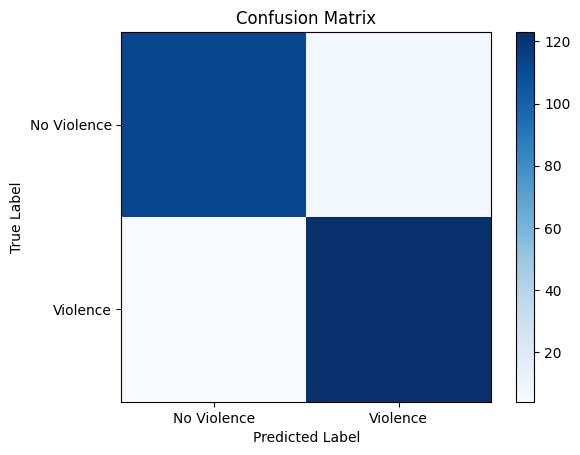

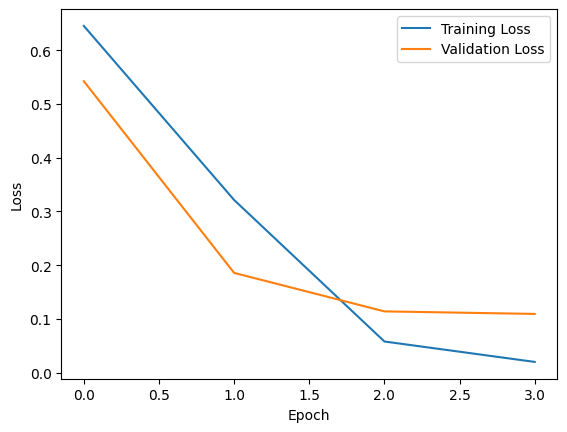

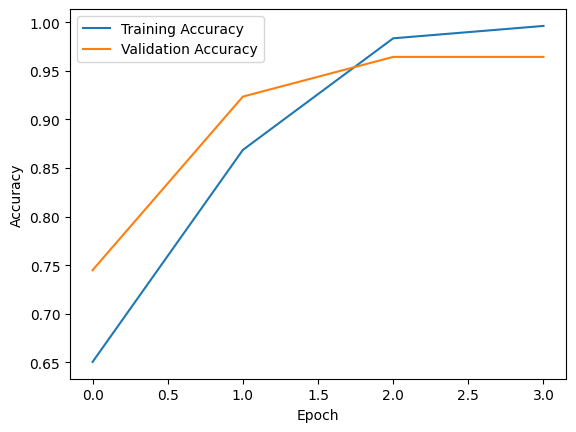

In [38]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()  # Make a copy to avoid SettingWithCopyWarning
test_data = shuffled_df[train_size:].copy()  # Make a copy to avoid SettingWithCopyWarning

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convertir les textes en séquences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convertir les labels en tableaux NumPy
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Création et entraînement du modèle avec batchs
batch_size = 32
epochs = 4

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Entraînement du modèle
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Évaluation du modèle sur les données de test
test_predictions = model.predict(test_sequences)
test_predictions = np.round(test_predictions).flatten()

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
test_roc_auc = roc_auc_score(test_labels, test_predictions)

# Affichage des résultats
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)

# Matrice de confusion
cm = confusion_matrix(test_labels, test_predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Courbes d'apprentissage
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Enregistrer le modèle
model.save("sentiment_model2.h5")


Epoch 1/10
49/49 [==============================] - 14s 165ms/step - loss: 0.5153 - accuracy: 0.7315 - val_loss: 0.2135 - val_accuracy: 0.9464
Epoch 2/10
49/49 [==============================] - 2s 38ms/step - loss: 0.0615 - accuracy: 0.9815 - val_loss: 0.0999 - val_accuracy: 0.9668
Epoch 3/10
49/49 [==============================] - 1s 15ms/step - loss: 0.0153 - accuracy: 0.9968 - val_loss: 0.0274 - val_accuracy: 0.9898
Epoch 4/10
49/49 [==============================] - 1s 15ms/step - loss: 0.0051 - accuracy: 0.9994 - val_loss: 0.0260 - val_accuracy: 0.9898
Epoch 5/10
49/49 [==============================] - 0s 8ms/step - loss: 0.0056 - accuracy: 0.9987 - val_loss: 0.0169 - val_accuracy: 0.9949
Epoch 6/10
49/49 [==============================] - 1s 11ms/step - loss: 0.0038 - accuracy: 0.9987 - val_loss: 0.0122 - val_accuracy: 0.9949
Epoch 7/10
49/49 [==============================] - 1s 11ms/step - loss: 0.0028 - accuracy: 0.9994 - val_loss: 0.0153 - val_accuracy: 0.9949
Epoch 8/10
4

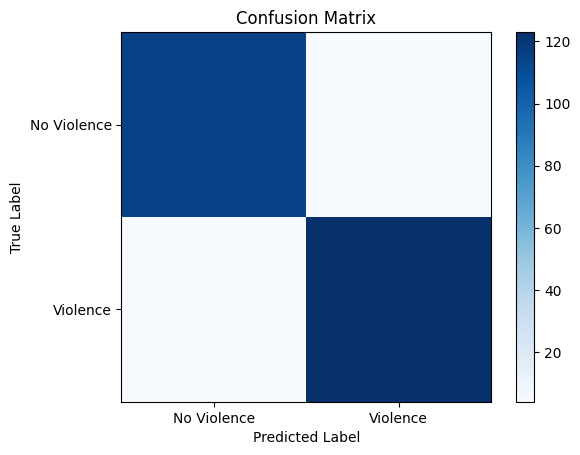

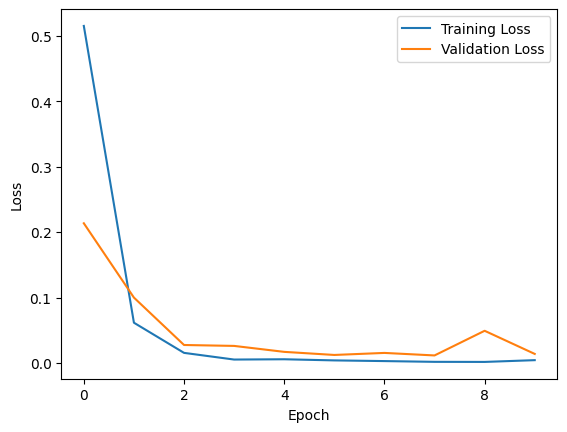

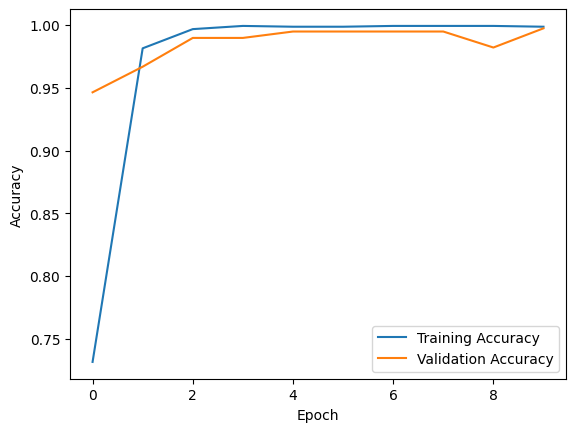

In [39]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)

# Convert texts to sequences
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if np.random.uniform(0, 1) > p]

augmented_train_sequences = [random_deletion(sequence) for sequence in train_sequences]
augmented_train_sequences = pad_sequences(augmented_train_sequences, maxlen=max_length)

# Combine original and augmented data
train_sequences = np.concatenate((train_sequences, augmented_train_sequences), axis=0)
train_labels = np.concatenate((train_labels, train_labels), axis=0)

# Hyperparameters for fine-tuning
batch_size = 32
epochs = 10

# Create and train the model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(LSTM(128))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define callbacks for early stopping and model checkpoint
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint("best_model.h5", save_best_only=True)

# Train the model with callbacks
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2,
                    callbacks=[early_stopping, model_checkpoint])


# Evaluate the model on the test data
test_predictions = best_model.predict(test_sequences)
test_predictions = np.round(test_predictions).flatten()

test_accuracy = accuracy_score(test_labels, test_predictions)
test_precision = precision_score(test_labels, test_predictions)
test_recall = recall_score(test_labels, test_predictions)
test_f1 = f1_score(test_labels, test_predictions)
test_roc_auc = roc_auc_score(test_labels, test_predictions)

# Display the results
print("Test Accuracy:", test_accuracy)
print("Test Precision:", test_precision)
print("Test Recall:", test_recall)
print("Test F1 Score:", test_f1)
print("Test ROC-AUC Score:", test_roc_auc)

# Confusion matrix
cm = confusion_matrix(test_labels, test_predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Learning curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the best model
best_model.save("sentiment_model3.h5")


Epoch 1/8
25/25 [==============================] - 11s 286ms/step - loss: 0.6433 - accuracy: 0.7015 - val_loss: 0.6117 - val_accuracy: 0.7347
Epoch 2/8
25/25 [==============================] - 2s 68ms/step - loss: 0.4371 - accuracy: 0.9324 - val_loss: 0.4082 - val_accuracy: 0.9337
Epoch 3/8
25/25 [==============================] - 1s 47ms/step - loss: 0.1704 - accuracy: 0.9681 - val_loss: 0.2218 - val_accuracy: 0.9439
Epoch 4/8
25/25 [==============================] - 1s 41ms/step - loss: 0.0484 - accuracy: 0.9936 - val_loss: 0.1447 - val_accuracy: 0.9745
Epoch 5/8
25/25 [==============================] - 1s 44ms/step - loss: 0.0160 - accuracy: 1.0000 - val_loss: 0.1181 - val_accuracy: 0.9643
Epoch 6/8
25/25 [==============================] - 0s 20ms/step - loss: 0.0080 - accuracy: 1.0000 - val_loss: 0.1061 - val_accuracy: 0.9643
Epoch 7/8
25/25 [==============================] - 1s 47ms/step - loss: 0.0048 - accuracy: 1.0000 - val_loss: 0.0991 - val_accuracy: 0.9643
Epoch 8/8
8/8 [===

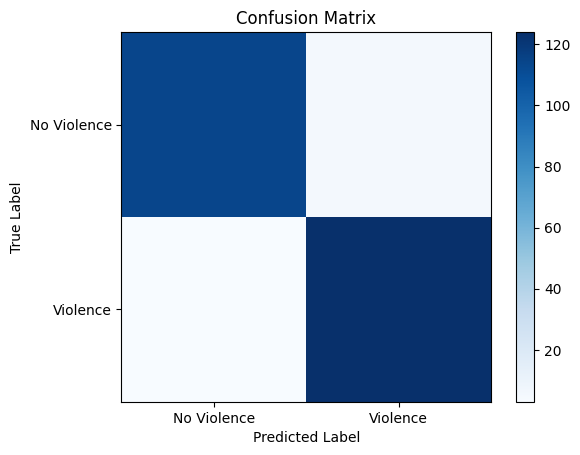

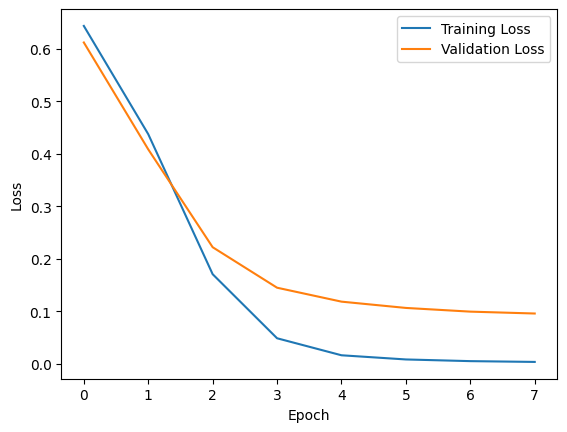

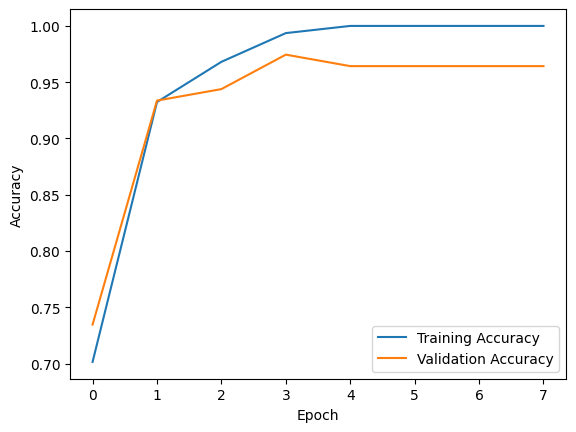

In [40]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense , Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

max_length = max([len(seq) for seq in train_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Create and train the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(Dropout(0.4))
model.add(GlobalMaxPooling1D())
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

batch_size = 32
epochs = 8

history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Evaluate the model on the test data
predictions = model.predict(test_sequences)
predictions = np.round(predictions).flatten()

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

# Display results and plots
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

cm = confusion_matrix(test_labels, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Save the model
model.save("sentiment_model4.h5")


Epoch 1/20
49/49 [==============================] - 12s 147ms/step - loss: 0.6923 - accuracy: 0.5128 - val_loss: 0.6886 - val_accuracy: 0.4872
Epoch 2/20
49/49 [==============================] - 3s 53ms/step - loss: 0.6836 - accuracy: 0.5886 - val_loss: 0.6813 - val_accuracy: 0.7474
Epoch 3/20
49/49 [==============================] - 0s 10ms/step - loss: 0.6765 - accuracy: 0.6499 - val_loss: 0.6721 - val_accuracy: 0.8929
Epoch 4/20
49/49 [==============================] - 1s 11ms/step - loss: 0.6666 - accuracy: 0.6837 - val_loss: 0.6593 - val_accuracy: 0.9337
Epoch 5/20
49/49 [==============================] - 2s 41ms/step - loss: 0.6447 - accuracy: 0.7577 - val_loss: 0.6400 - val_accuracy: 0.9235
Epoch 6/20
49/49 [==============================] - 2s 32ms/step - loss: 0.6220 - accuracy: 0.8042 - val_loss: 0.6093 - val_accuracy: 0.9413
Epoch 7/20
49/49 [==============================] - 1s 25ms/step - loss: 0.5819 - accuracy: 0.8578 - val_loss: 0.5647 - val_accuracy: 0.9566
Epoch 8/20


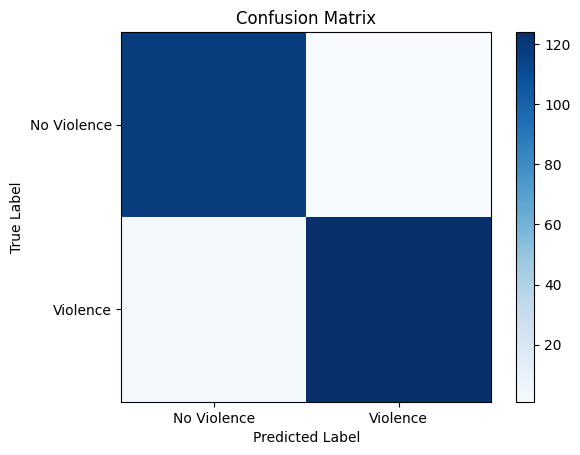

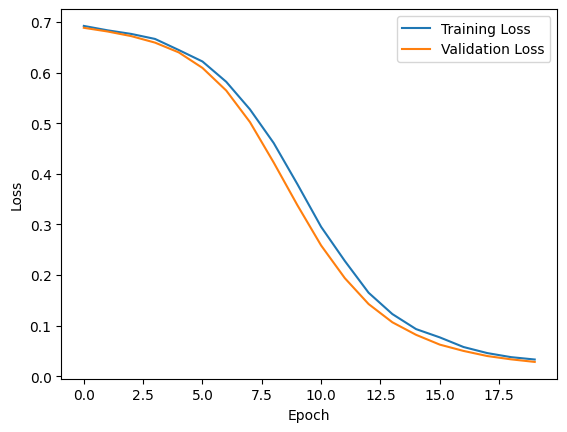

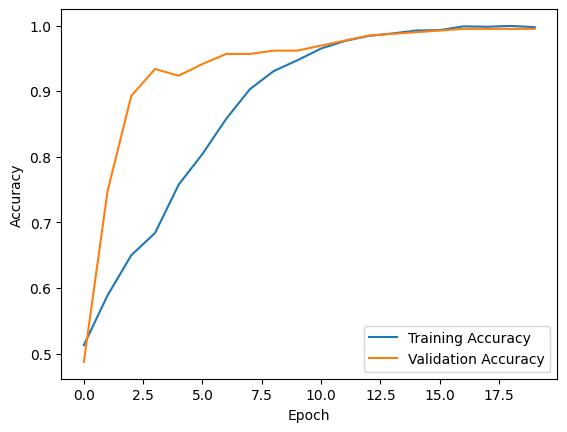

In [42]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  # Use train_texts instead of texts
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if random.uniform(0, 1) > p]

augmented_sequences = [random_deletion(sequence) for sequence in train_sequences]

# Convert augmented_sequences to a 2D array
augmented_sequences = pad_sequences(augmented_sequences, maxlen=max_length)

# Concatenate train_sequences and augmented_sequences
train_sequences = np.concatenate((train_sequences, augmented_sequences), axis=0)

# Create augmented_labels
augmented_labels = np.array([label for label in train_labels for _ in range(len(augmented_sequences) // len(train_labels))])

# Concatenate train_labels and augmented_labels
train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

# Create and train the CNN model with batches
batch_size = 32
epochs = 20
learning_rate = 0.0001

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Save the model
model.save("sentiment_model5.h5")

# Evaluate the model on the test data
predictions = model.predict(test_sequences)
predictions = np.round(predictions).flatten()

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Confusion Matrix
cm = confusion_matrix(test_labels, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Learning Curves
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


Epoch 1/20
49/49 [==============================] - 6s 94ms/step - loss: 0.2672 - accuracy: 0.8756 - val_loss: 0.0462 - val_accuracy: 0.9872
Epoch 2/20
49/49 [==============================] - 2s 49ms/step - loss: 0.0528 - accuracy: 0.9821 - val_loss: 0.0078 - val_accuracy: 0.9949
Epoch 3/20
49/49 [==============================] - 1s 23ms/step - loss: 0.0036 - accuracy: 0.9994 - val_loss: 0.0108 - val_accuracy: 0.9949
Epoch 4/20
49/49 [==============================] - 0s 9ms/step - loss: 0.0049 - accuracy: 0.9981 - val_loss: 0.0046 - val_accuracy: 0.9974
Epoch 5/20
49/49 [==============================] - 1s 16ms/step - loss: 0.0186 - accuracy: 0.9943 - val_loss: 0.0466 - val_accuracy: 0.9898
Epoch 6/20
49/49 [==============================] - 1s 20ms/step - loss: 0.1007 - accuracy: 0.9885 - val_loss: 0.0192 - val_accuracy: 0.9923
Epoch 7/20
49/49 [==============================] - 1s 10ms/step - loss: 0.0429 - accuracy: 0.9936 - val_loss: 0.0241 - val_accuracy: 0.9949
Epoch 8/20
49/

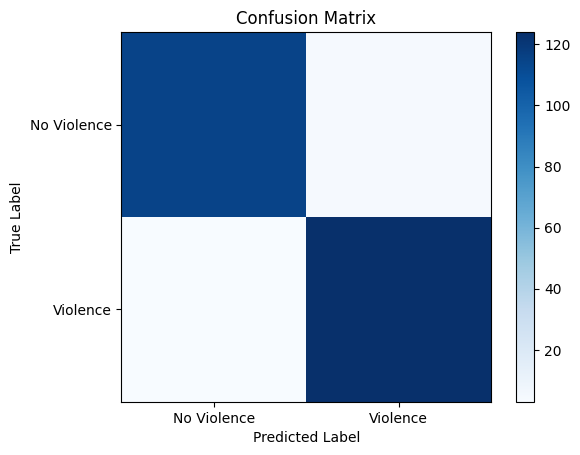

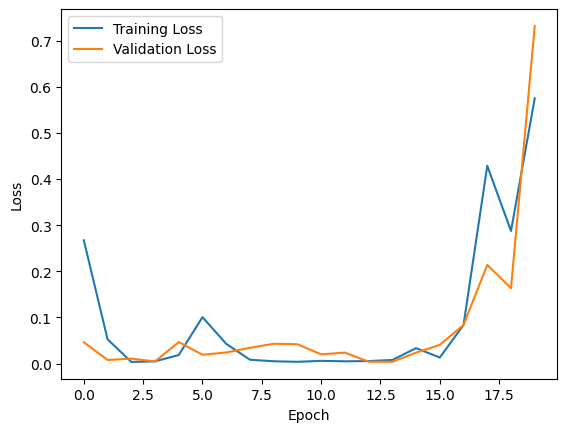

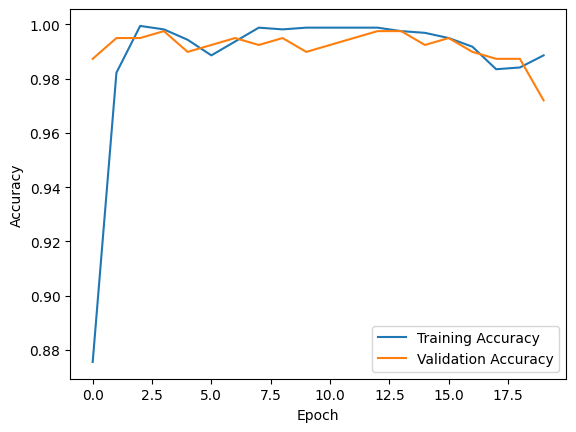

In [43]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  # Use train_texts instead of texts
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if random.uniform(0, 1) > p]

augmented_sequences = [random_deletion(sequence) for sequence in train_sequences]

# Convert augmented_sequences to a 2D array
augmented_sequences = pad_sequences(augmented_sequences, maxlen=max_length)

# Concatenate train_sequences and augmented_sequences
train_sequences = np.concatenate((train_sequences, augmented_sequences), axis=0)

# Create augmented_labels
augmented_labels = np.array([label for label in train_labels for _ in range(len(augmented_sequences) // len(train_labels))])

# Concatenate train_labels and augmented_labels
train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

# Create and train the CNN model with batches
batch_size = 32
epochs = 20
learning_rate = 0.01

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Utilisation de la méthode fit avec batch_size et enregistrement de l'historique
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Sauvegarder le modèle
model.save("sentiment_model6.h5")

# Évaluation du modèle sur les données de test
predictions = model.predict(test_sequences)
predictions = np.round(predictions).flatten()

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Matrice de confusion
cm = confusion_matrix(test_labels, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Courbes d'apprentissage
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the trained model
model = load_model("sentiment_model0.h5")

# Prepare the text for prediction
new_texts = ["violance "]  # List of texts to predict

# Tokenization for new data
tokenizer = Tokenizer()
# Update tokenizer with the vocabulary used during training
tokenizer.fit_on_texts(new_texts)
new_sequences = tokenizer.texts_to_sequences(new_texts)
max_length = model.input_shape[1]
new_sequences = pad_sequences(new_sequences, maxlen=max_length)

# Make predictions on the new data
predictions = model.predict(new_sequences)
print(predictions)
predicted_label = int(np.round(predictions).flatten()[0])

# Display the predicted label
print("Predicted Label:", predicted_label)


1/1 [==============================] - 2s 2s/step
[[0.23347588]]
Predicted Label: 0


Epoch 1/20
49/49 [==============================] - 8s 96ms/step - loss: 0.6943 - accuracy: 0.4987 - val_loss: 0.6933 - val_accuracy: 0.4898
Epoch 2/20
49/49 [==============================] - 3s 51ms/step - loss: 0.6935 - accuracy: 0.4872 - val_loss: 0.6933 - val_accuracy: 0.4898
Epoch 3/20
49/49 [==============================] - 1s 22ms/step - loss: 0.6943 - accuracy: 0.4904 - val_loss: 0.6932 - val_accuracy: 0.4898
Epoch 4/20
49/49 [==============================] - 2s 39ms/step - loss: 0.6935 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.4949
Epoch 5/20
49/49 [==============================] - 1s 20ms/step - loss: 0.6955 - accuracy: 0.4821 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 6/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6919 - accuracy: 0.5191 - val_loss: 0.6930 - val_accuracy: 0.5026
Epoch 7/20
49/49 [==============================] - 1s 15ms/step - loss: 0.6928 - accuracy: 0.5051 - val_loss: 0.6930 - val_accuracy: 0.5077
Epoch 8/20
49

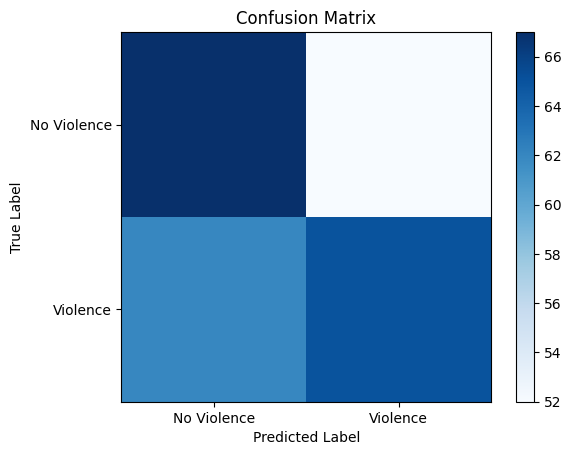

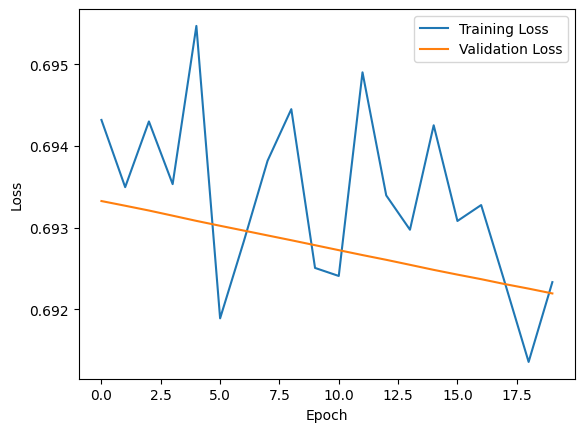

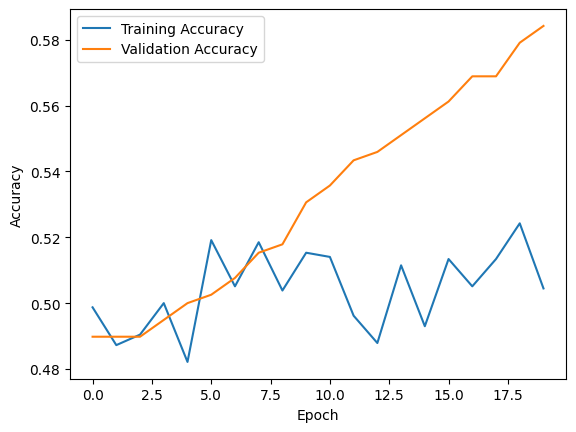

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf  # Import the TensorFlow module

# Load the dataset from Excel
df = pd.read_excel("Dataset.xlsx")

# Shuffle the data
shuffled_df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Split the shuffled data into training and testing sets
train_size = int(0.8 * len(shuffled_df))
train_data = shuffled_df[:train_size].copy()
test_data = shuffled_df[train_size:].copy()

# Map and convert the labels to integers
label_mapping = {'non violence médicale': 0, 'violence médicale': 1}
train_labels = train_data['resultat'].map(label_mapping).astype(int)
test_labels = test_data['resultat'].map(label_mapping).astype(int)

# Assuming 'data' is the text column
train_texts = train_data['data'].tolist()
test_texts = test_data['data'].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_texts)  # Use train_texts instead of texts
train_sequences = tokenizer.texts_to_sequences(train_texts)
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Pad sequences
max_length = max([len(seq) for seq in train_sequences + test_sequences])
train_sequences = pad_sequences(train_sequences, maxlen=max_length)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Convert labels to NumPy arrays
train_labels = np.array(train_labels)
test_labels = np.array(test_labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if random.uniform(0, 1) > p]

augmented_sequences = [random_deletion(sequence) for sequence in train_sequences]

# Convert augmented_sequences to a 2D array
augmented_sequences = pad_sequences(augmented_sequences, maxlen=max_length)

# Concatenate train_sequences and augmented_sequences
train_sequences = np.concatenate((train_sequences, augmented_sequences), axis=0)

# Create augmented_labels
augmented_labels = np.array([label for label in train_labels for _ in range(len(augmented_sequences) // len(train_labels))])

# Concatenate train_labels and augmented_labels
train_labels = np.concatenate((train_labels, augmented_labels), axis=0)

# Create and train the CNN model with batches
batch_size = 32
epochs = 20
learning_rate = 0.000001

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))  # Add a dropout layer with 50% dropout rate
model.add(Dense(64, activation='relu'))  # Add a dense layer
model.add(Dropout(0.5))  # Add another dropout layer with 50% dropout rate
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Utilisation de la méthode fit avec batch_size et enregistrement de l'historique
history = model.fit(train_sequences, train_labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Sauvegarder le modèle
model.save("sentiment_model4.h5")

# Évaluation du modèle sur les données de test
predictions = model.predict(test_sequences)
predictions = np.round(predictions).flatten()

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Matrice de confusion
cm = confusion_matrix(test_labels, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Courbes d'apprentissage
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


object
object
Epoch 1/100
31/31 [==============================] - 2s 22ms/step - loss: 0.6962 - accuracy: 0.4469 - val_loss: 0.6951 - val_accuracy: 0.4228
Epoch 2/100
31/31 [==============================] - 1s 17ms/step - loss: 0.6944 - accuracy: 0.4857 - val_loss: 0.6950 - val_accuracy: 0.4228
Epoch 3/100
31/31 [==============================] - 1s 16ms/step - loss: 0.6939 - accuracy: 0.4847 - val_loss: 0.6950 - val_accuracy: 0.4268
Epoch 4/100
31/31 [==============================] - 1s 16ms/step - loss: 0.6945 - accuracy: 0.4867 - val_loss: 0.6949 - val_accuracy: 0.4309
Epoch 5/100
31/31 [==============================] - 0s 15ms/step - loss: 0.6948 - accuracy: 0.4765 - val_loss: 0.6949 - val_accuracy: 0.4309
Epoch 6/100
31/31 [==============================] - 1s 18ms/step - loss: 0.6951 - accuracy: 0.4724 - val_loss: 0.6948 - val_accuracy: 0.4350
Epoch 7/100
31/31 [==============================] - 0s 16ms/step - loss: 0.6955 - accuracy: 0.4694 - val_loss: 0.6947 - val_accuracy:

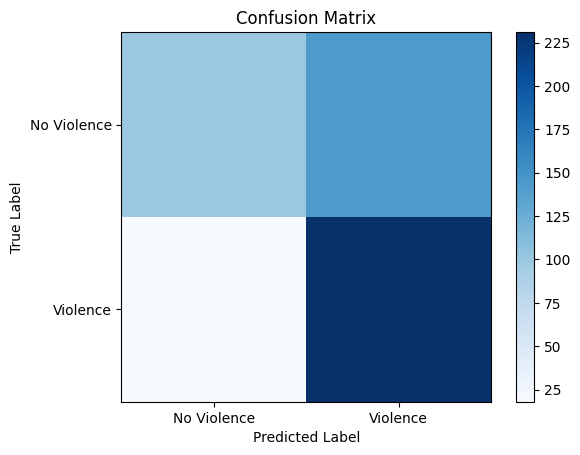

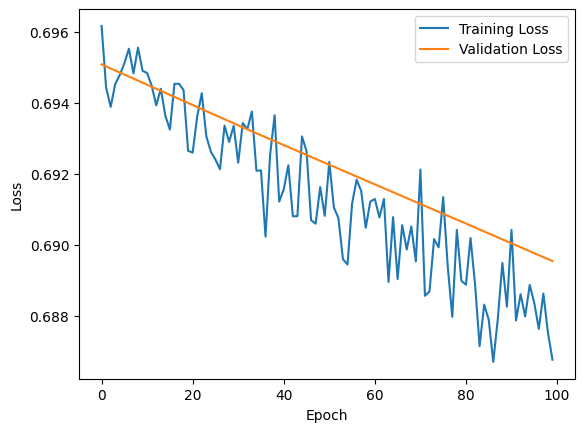

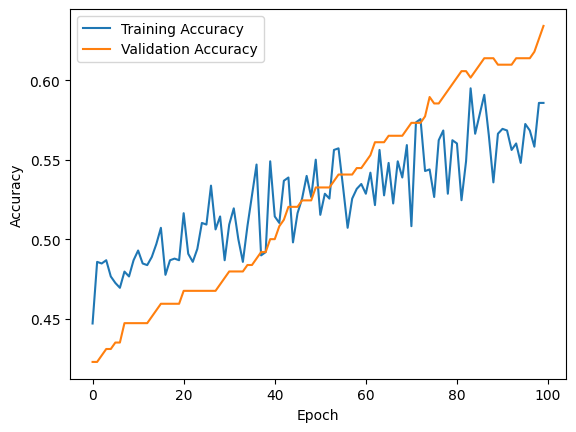

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf  # Import the TensorFlow module

# Lire le fichier Excel
df = pd.read_excel("Dataset.xlsx")

# Mélanger les données pour éviter tout biais
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérifier que les colonnes sont du texte
print(df['data'].dtype)
print(df['resultat'].dtype)

# Convertir en str si nécessaire
df['data'] = df['data'].astype(str)

# Mapper les étiquettes 'resultat' en 0 ou 1
df['resultat'] = df['resultat'].map({'pas de violence médicale': 0, 'violence médicale': 1})

# Remplacer les valeurs manquantes (NaN) par 0
df['resultat'].fillna(0, inplace=True)

# Convertir en type entier (int)
df['resultat'] = df['resultat'].astype(int)

# Extraire les colonnes
texts = df["data"].tolist()
labels = df["resultat"].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length)

# Convertir la liste 'labels' en un tableau NumPy
labels = np.array(labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if random.uniform(0, 1) > p]

augmented_sequences = [random_deletion(sequence) for sequence in sequences]

# Create augmented data
augmented_texts = [tokenizer.sequences_to_texts([sequence])[0] for sequence in augmented_sequences]
augmented_labels = np.array([label for label in labels for _ in range(len(augmented_texts)//len(labels))])

texts += augmented_texts
labels = np.concatenate((labels, augmented_labels))

# Diviser les données en train et test (80% train, 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization pour les données de test
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Création et entraînement du modèle CNN avec batchs
batch_size = 32  # Taille du batch
epochs = 100  # Nombre d'époques
learning_rate = 0.000001  # Learning rate

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))  # Add a dropout layer with 50% dropout rate
model.add(Dense(64, activation='relu'))  # Add a dense layer
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.RMSprop(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])


# Utilisation de la méthode fit avec batch_size et enregistrement de l'historique
history = model.fit(sequences, labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Sauvegarder le modèle
model.save("sentiment_model5.h5")

# Évaluation du modèle sur les données de test
predictions = model.predict(test_sequences)
predictions = np.round(predictions).flatten()

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Matrice de confusion
cm = confusion_matrix(test_labels, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Courbes d'apprentissage
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



object
object
Epoch 1/10
31/31 [==============================] - 2s 24ms/step - loss: 1.6045 - accuracy: 0.6663 - val_loss: 0.4858 - val_accuracy: 0.7805
Epoch 2/10
31/31 [==============================] - 1s 18ms/step - loss: 0.6865 - accuracy: 0.6888 - val_loss: 0.7269 - val_accuracy: 0.4837
Epoch 3/10
31/31 [==============================] - 1s 27ms/step - loss: 0.6981 - accuracy: 0.5082 - val_loss: 0.6928 - val_accuracy: 0.5163
Epoch 4/10
31/31 [==============================] - 1s 30ms/step - loss: 0.6942 - accuracy: 0.5061 - val_loss: 0.6929 - val_accuracy: 0.5163
Epoch 5/10
31/31 [==============================] - 1s 29ms/step - loss: 0.6949 - accuracy: 0.4776 - val_loss: 0.6930 - val_accuracy: 0.5163
Epoch 6/10
31/31 [==============================] - 1s 31ms/step - loss: 0.6936 - accuracy: 0.5061 - val_loss: 0.6928 - val_accuracy: 0.5163
Epoch 7/10
31/31 [==============================] - 1s 29ms/step - loss: 0.6940 - accuracy: 0.4837 - val_loss: 0.6927 - val_accuracy: 0.5163

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


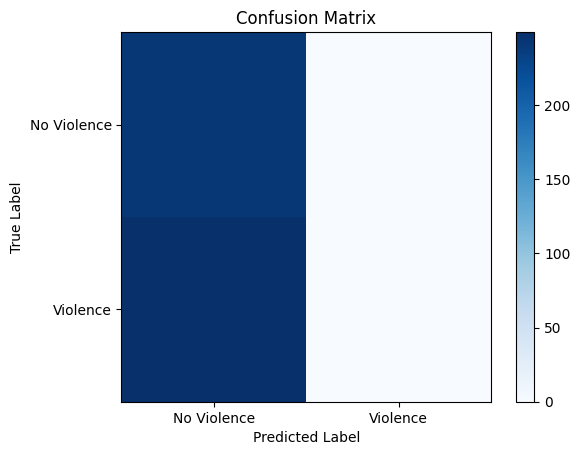

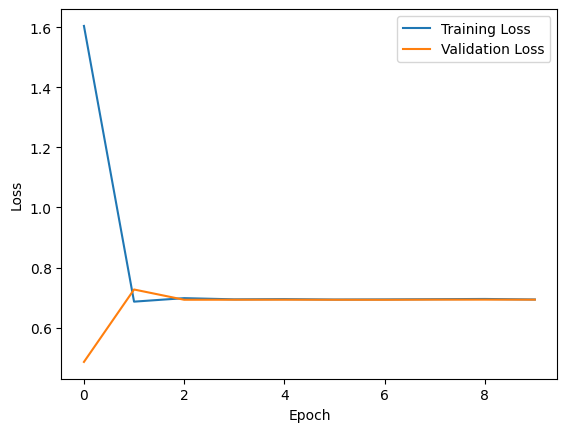

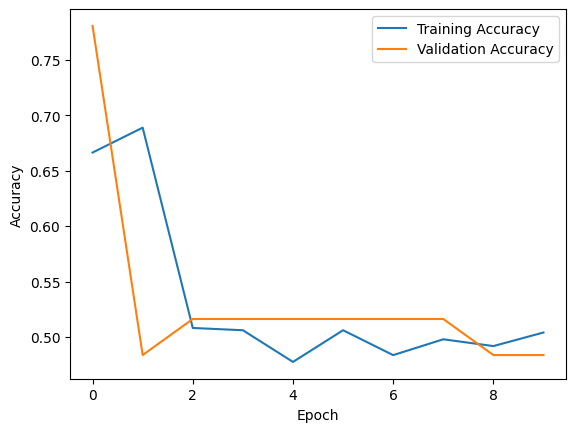

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import random
import tensorflow as tf  # Import the TensorFlow module

# Lire le fichier Excel
df = pd.read_excel("Dataset.xlsx")

# Mélanger les données pour éviter tout biais
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérifier que les colonnes sont du texte
print(df['data'].dtype)
print(df['resultat'].dtype)

# Convertir en str si nécessaire
df['data'] = df['data'].astype(str)

# Mapper les étiquettes 'resultat' en 0 ou 1
df['resultat'] = df['resultat'].map({'pas de violence médicale': 0, 'violence médicale': 1})

# Remplacer les valeurs manquantes (NaN) par 0
df['resultat'].fillna(0, inplace=True)

# Convertir en type entier (int)
df['resultat'] = df['resultat'].astype(int)

# Extraire les colonnes
texts = df["data"].tolist()
labels = df["resultat"].tolist()

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

# Pad sequences
max_length = max([len(seq) for seq in sequences])
sequences = pad_sequences(sequences, maxlen=max_length)

# Convertir la liste 'labels' en un tableau NumPy
labels = np.array(labels)

# Data augmentation
def random_deletion(sequence, p=0.1):
    return [word for word in sequence if random.uniform(0, 1) > p]

augmented_sequences = [random_deletion(sequence) for sequence in sequences]

# Create augmented data
augmented_texts = [tokenizer.sequences_to_texts([sequence])[0] for sequence in augmented_sequences]
augmented_labels = np.array([label for label in labels for _ in range(len(augmented_texts)//len(labels))])

texts += augmented_texts
labels = np.concatenate((labels, augmented_labels))

# Diviser les données en train et test (80% train, 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Tokenization pour les données de test
test_sequences = tokenizer.texts_to_sequences(test_texts)
test_sequences = pad_sequences(test_sequences, maxlen=max_length)

# Création et entraînement du modèle CNN avec batchs
batch_size = 32  # Taille du batch
epochs = 10  # Nombre d'époques
learning_rate = 0.1  # Learning rate

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_length))
model.add(Conv1D(128, 5, activation='relu'))
model.add(GlobalMaxPooling1D())
# Add a dropout layer with 50% dropout rate
model.add(Dense(64, activation='relu'))  # Add a dense layer # Add another dropout layer with 50% dropout rate
model.add(Dense(1, activation='sigmoid'))

optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Utilisation de la méthode fit avec batch_size et enregistrement de l'historique
history = model.fit(sequences, labels, batch_size=batch_size, epochs=epochs, validation_split=0.2)

# Sauvegarder le modèle
model.save("sentiment_model6.h5")

# Évaluation du modèle sur les données de test
predictions = model.predict(test_sequences)
predictions = np.round(predictions).flatten()

accuracy = accuracy_score(test_labels, predictions)
precision = precision_score(test_labels, predictions)
recall = recall_score(test_labels, predictions)
f1 = f1_score(test_labels, predictions)
roc_auc = roc_auc_score(test_labels, predictions)

# Affichage des résultats
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("ROC-AUC Score:", roc_auc)

# Matrice de confusion
cm = confusion_matrix(test_labels, predictions)
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["No Violence", "Violence"])
plt.yticks(tick_marks, ["No Violence", "Violence"])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Courbes d'apprentissage
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()



In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

# Mélanger les données pour éviter tout biais
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# Vérifier que les colonnes sont du texte
print(df['data'].dtype)
print(df['resultat'].dtype)

# Convertir en str si nécessaire
df['data'] = df['data'].astype(str)

# Mapper les étiquettes 'resultat' en 0 ou 1
df['resultat'] = df['resultat'].map({'pas de violence médicale': 0, 'violence médicale': 1})

# Remplacer les valeurs manquantes (NaN) par 0
df['resultat'].fillna(0, inplace=True)

# Convertir en type entier (int)
df['resultat'] = df['resultat'].astype(int)

# Extraire les colonnes
texts = df["data"].tolist()
labels = df["resultat"].tolist()

# Convertir les listes en numpy arrays
texts = np.array(texts)
labels = np.array(labels)

# Diviser les données en train et test (80% train, 20% test)
train_texts, test_texts, train_labels, test_labels = train_test_split(texts, labels, test_size=0.2, random_state=42, shuffle=True)

# Print the lengths of the resulting lists
print("Train texts length:", len(train_texts))
print("Test texts length:", len(test_texts))
print("Train labels length:", len(train_labels))
print("Test labels length:", len(test_labels))


object
int64
Train texts length: 980
Test texts length: 246
Train labels length: 980
Test labels length: 246


In [48]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Load the saved model
model = load_model("sentiment_model3.h5")

# Load and preprocess the new text examples
new_text_examples = [
    "C'était une expérience médicale positive et rassurante.",
    "Le médecin a été très agressif et malhonnête.",
    "J'ai été bien traité lors de ma visite à l'hôpital."
]

# Tokenization and padding
tokenizer = Tokenizer()
tokenizer.fit_on_texts(new_text_examples)
sequences = tokenizer.texts_to_sequences(new_text_examples)
max_length = model.input_shape[1]
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# Make predictions
predicted_labels = model.predict(padded_sequences).flatten()


# Print the predictions
for i, text in enumerate(new_text_examples):
    sentiment = "Violence médicale" if predicted_labels[i] > 0.5 else "Non violence médicale"
    print(f"Text: {text}\nPredicted Sentiment: {sentiment}\n")
    print(predicted_labels[i])

1/1 [==============================] - 1s 662ms/step
Text: C'était une expérience médicale positive et rassurante.
Predicted Sentiment: Non violence médicale

0.030550977
Text: Le médecin a été très agressif et malhonnête.
Predicted Sentiment: Violence médicale

0.99118996
Text: J'ai été bien traité lors de ma visite à l'hôpital.
Predicted Sentiment: Violence médicale

0.71852547


In [54]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Define a list of model file names along with their corresponding names
model_files = [
    ("sentiment_model0.h5", "Sentiment Model 0"),
    ("sentiment_model1.h5", "Sentiment Model 1"),
    ("sentiment_model2.h5", "Sentiment Model 2"),
    ("sentiment_model3.h5", "Sentiment Model 3"),
    ("sentiment_model4.h5", "Sentiment Model 4"),
    ("sentiment_model5.h5", "Sentiment Model 5"),
    ("sentiment_model6.h5", "Sentiment Model 6"),
    ("best_model.h5", "Best Model"),
    ("best_model2.h5", "Best Model 2")
]

# Load and preprocess the new text examples
new_text_examples = [
    ("C'était une expérience médicale positive et rassurante.", 0),
    ("Le médecin a été très agressif et malhonnête.", 1),
    ("J'ai été bien traité lors de ma visite à l'hôpital.", 0)
]

# Create an empty DataFrame to store the results
results = pd.DataFrame(columns=["Text", "Reality", "Predicted Sentiment", "Model Number", "Model Name", "Prediction Score"])

for model_number, (model_file, model_name) in enumerate(model_files):
    # Load the saved model
    model = load_model(model_file)

    # Tokenization and padding
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts([text for text, _ in new_text_examples])
    sequences = tokenizer.texts_to_sequences([text for text, _ in new_text_examples])
    max_length = model.input_shape[1]
    padded_sequences = pad_sequences(sequences, maxlen=max_length)

    # Make predictions
    predicted_labels = model.predict(padded_sequences).flatten()

    # Add the predictions to the results DataFrame
    for (text, reality), predicted_label in zip(new_text_examples, predicted_labels):
        sentiment = "Violence médicale" if predicted_label > 0.5 else "Non violence médicale"
        results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
                                  "Model Number": model_number, "Model Name": model_name,
                                  "Prediction Score": predicted_label},
                                 ignore_index=True)

# Save the results to an Excel file
results.to_excel("result.xlsx", index=False)

print("Results saved to result.xlsx")


1/1 [==============================] - 1s 1s/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 1s 665ms/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 1s 623ms/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 1s 1s/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 0s 116ms/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 0s 222ms/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 0s 148ms/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 1s 1s/step


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


1/1 [==============================] - 0s 421ms/step
Results saved to result.xlsx


<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,
<ipython-input-54-12fa15b7581d>:47: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append({"Text": text, "Reality": reality, "Predicted Sentiment": sentiment,


<Figure size 1000x600 with 0 Axes>

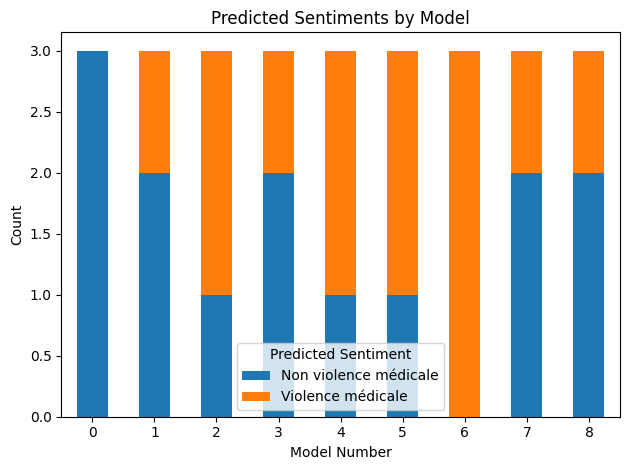

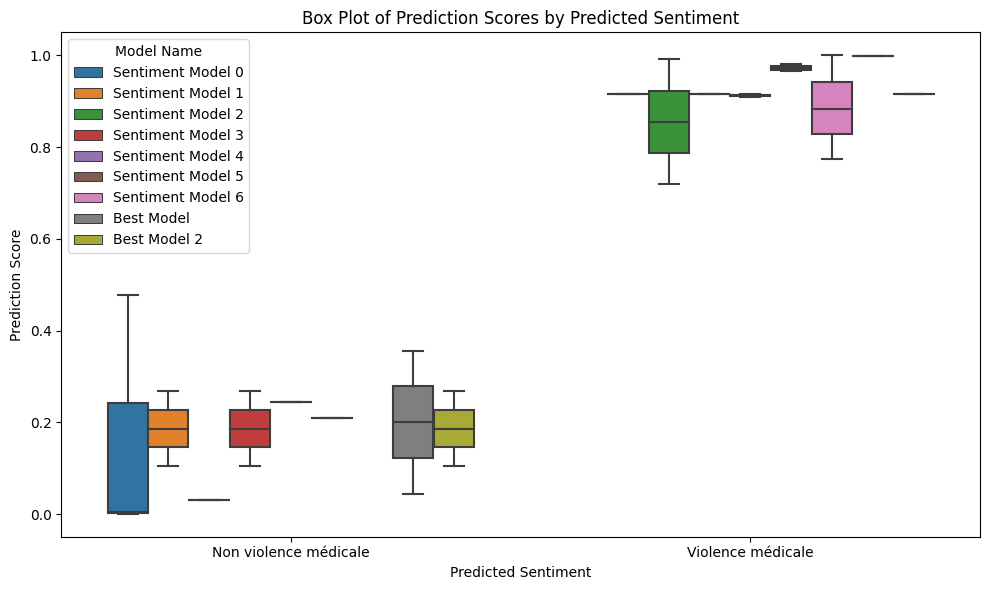

In [55]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file into a DataFrame
results = pd.read_excel("result.xlsx")

# Create a bar plot of predicted sentiments by model
plt.figure(figsize=(10, 6))
sentiment_counts = results.groupby(["Model Number", "Predicted Sentiment"]).size().unstack().fillna(0)
sentiment_counts.plot(kind="bar", stacked=True)
plt.title("Predicted Sentiments by Model")
plt.xlabel("Model Number")
plt.ylabel("Count")
plt.xticks(rotation=0)
plt.legend(title="Predicted Sentiment")
plt.tight_layout()
plt.show()

# Create a box plot of prediction scores by predicted sentiment
plt.figure(figsize=(10, 6))
sns.boxplot(data=results, x="Predicted Sentiment", y="Prediction Score", hue="Model Name")
plt.title("Box Plot of Prediction Scores by Predicted Sentiment")
plt.xlabel("Predicted Sentiment")
plt.ylabel("Prediction Score")
plt.legend(title="Model Name")
plt.tight_layout()
plt.show()


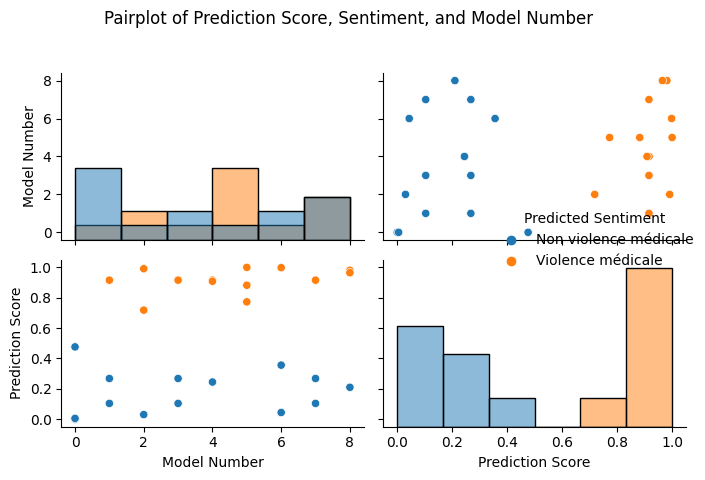

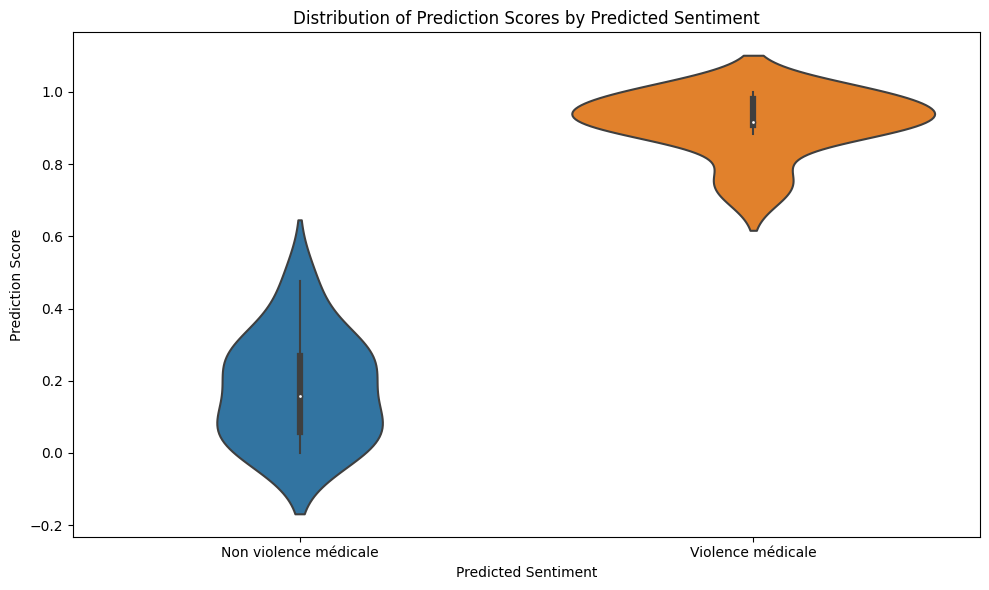

In [52]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file into a DataFrame
results = pd.read_excel("result.xlsx")

# Create a pairplot to visualize relationships between prediction score, sentiment, and model number
sns.pairplot(results, hue="Predicted Sentiment", diag_kind="hist")
plt.suptitle("Pairplot of Prediction Score, Sentiment, and Model Number")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Create a violin plot to show the distribution of prediction scores by sentiment
plt.figure(figsize=(10, 6))
sns.violinplot(data=results, x="Predicted Sentiment", y="Prediction Score")
plt.title("Distribution of Prediction Scores by Predicted Sentiment")
plt.xlabel("Predicted Sentiment")
plt.ylabel("Prediction Score")
plt.tight_layout()
plt.show()


<ipython-input-53-dc06ca936277>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = results.corr()


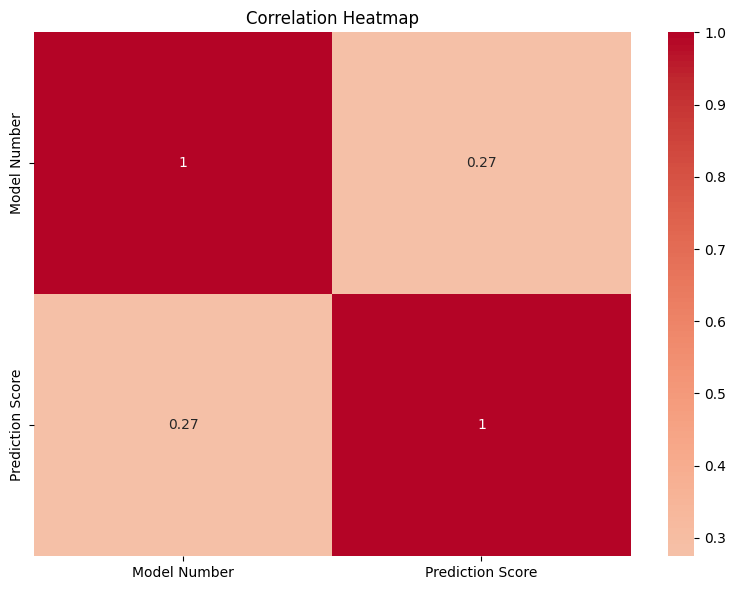

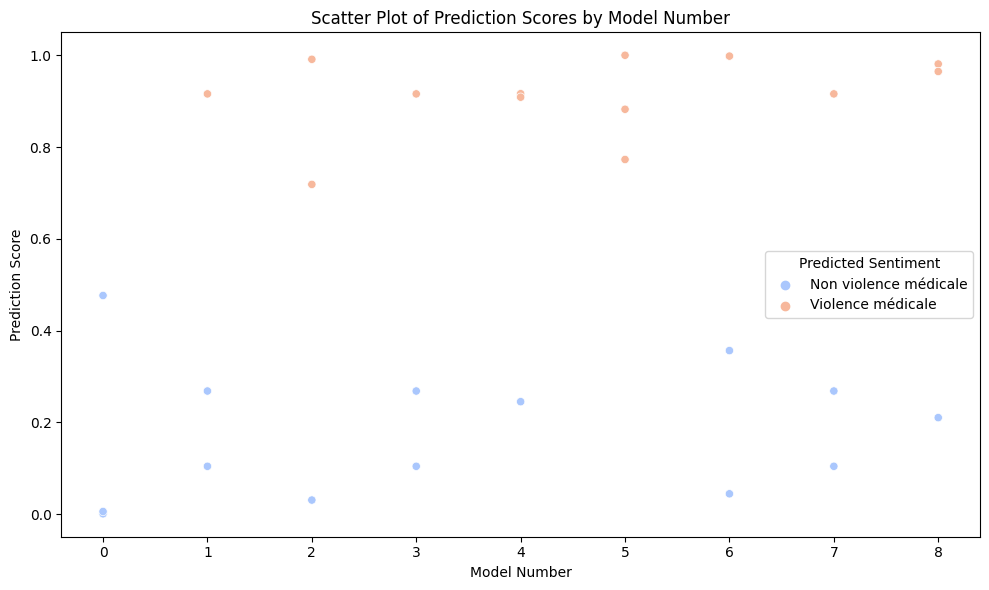

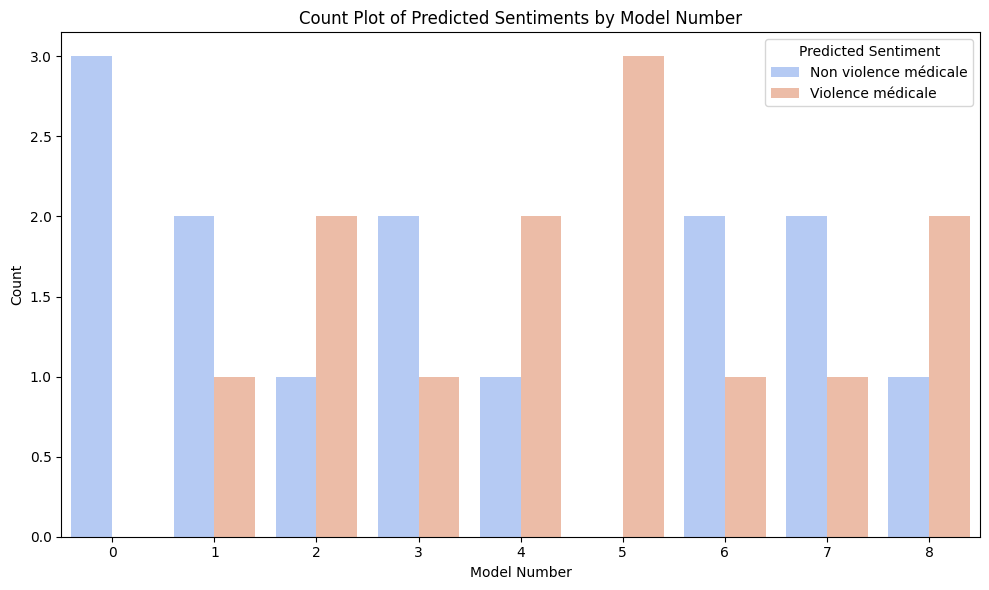

In [53]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file into a DataFrame
results = pd.read_excel("result.xlsx")

# Create a heatmap of correlation between variables
corr_matrix = results.corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Create a scatter plot of prediction scores by model number
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x="Model Number", y="Prediction Score", hue="Predicted Sentiment", palette="coolwarm")
plt.title("Scatter Plot of Prediction Scores by Model Number")
plt.xlabel("Model Number")
plt.ylabel("Prediction Score")
plt.tight_layout()
plt.show()

# Create a count plot of predicted sentiments by model number
plt.figure(figsize=(10, 6))
sns.countplot(data=results, x="Model Number", hue="Predicted Sentiment", palette="coolwarm")
plt.title("Count Plot of Predicted Sentiments by Model Number")
plt.xlabel("Model Number")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


<ipython-input-56-c8c90b3da2dd>:9: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = results.corr()


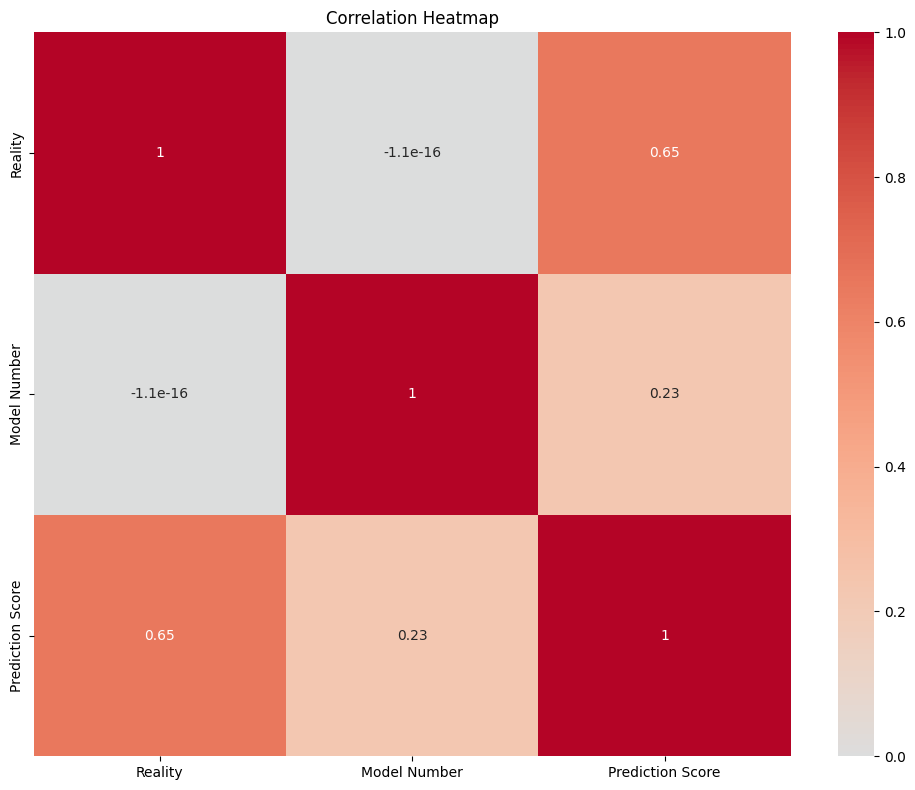

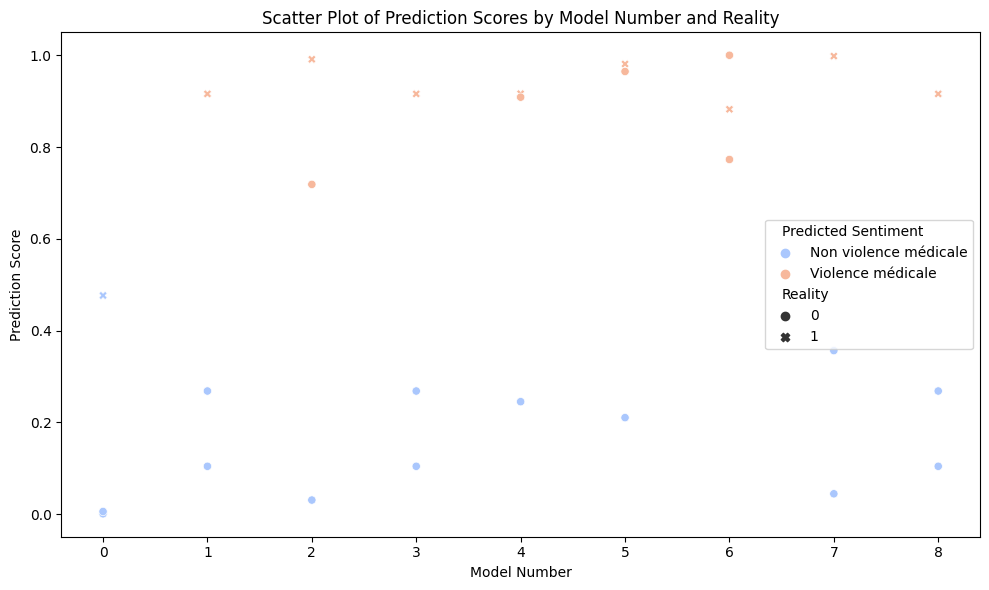

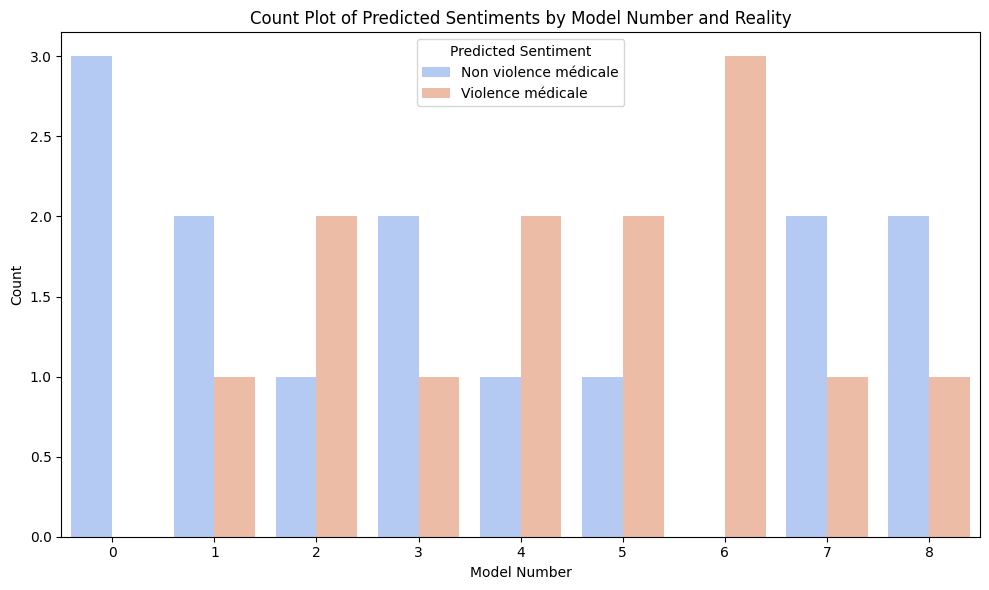

In [56]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file into a DataFrame
results = pd.read_excel("result.xlsx")

# Create a heatmap of correlation between variables
corr_matrix = results.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.tight_layout()
plt.show()

# Create a scatter plot of prediction scores by model number and reality
plt.figure(figsize=(10, 6))
sns.scatterplot(data=results, x="Model Number", y="Prediction Score", hue="Predicted Sentiment",
                palette="coolwarm", style="Reality")
plt.title("Scatter Plot of Prediction Scores by Model Number and Reality")
plt.xlabel("Model Number")
plt.ylabel("Prediction Score")
plt.tight_layout()
plt.show()

# Create a count plot of predicted sentiments by model number and reality
plt.figure(figsize=(10, 6))
sns.countplot(data=results, x="Model Number", hue="Predicted Sentiment", palette="coolwarm", hue_order=["Non violence médicale", "Violence médicale"])
plt.title("Count Plot of Predicted Sentiments by Model Number and Reality")
plt.xlabel("Model Number")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


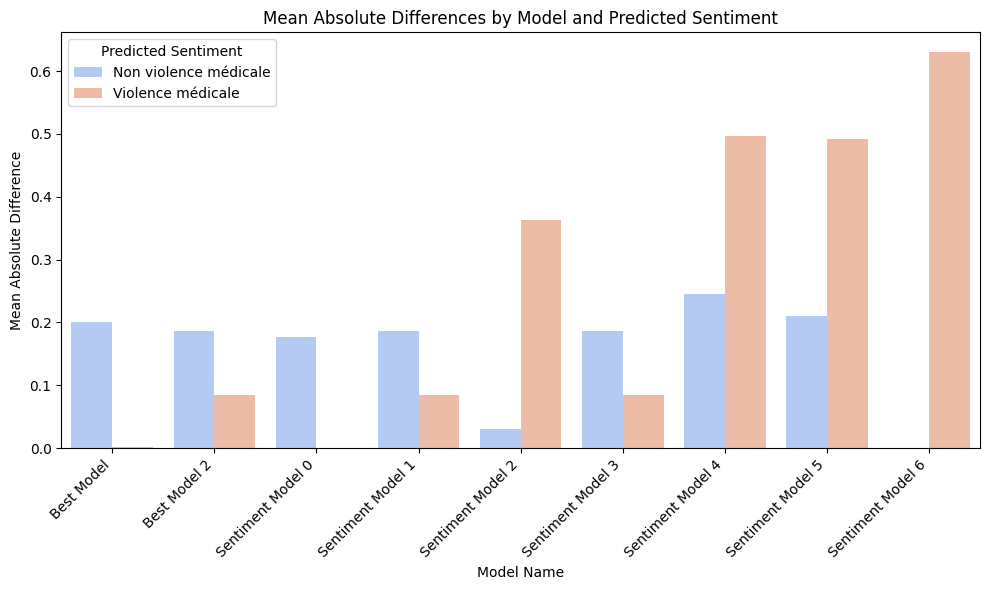

Best Models for Each Sentiment:
     Predicted Sentiment  Model Name
0  Non violence médicale  Best Model
1      Violence médicale  Best Model
Overall Best Model: Best Model (Non violence médicale)


In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Read the Excel file into a DataFrame
results = pd.read_excel("result.xlsx")

# Calculate absolute differences between prediction scores and reality
results["Absolute Difference"] = abs(results["Reality"] - results["Prediction Score"])

# Calculate Mean Absolute Differences (MAD) by model and predicted sentiment
mad_by_model = results.groupby(["Model Name", "Predicted Sentiment"])["Absolute Difference"].mean().reset_index()

# Find the model with the lowest MAD for each sentiment
best_models = mad_by_model.groupby("Predicted Sentiment")["Model Name"].min().reset_index()

# Create a bar plot of Mean Absolute Differences by model and predicted sentiment
plt.figure(figsize=(10, 6))
sns.barplot(data=mad_by_model, x="Model Name", y="Absolute Difference", hue="Predicted Sentiment", palette="coolwarm")
plt.title("Mean Absolute Differences by Model and Predicted Sentiment")
plt.xlabel("Model Name")
plt.ylabel("Mean Absolute Difference")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.legend(title="Predicted Sentiment")
plt.show()

# Display the best model for each sentiment
print("Best Models for Each Sentiment:")
print(best_models)

# Determine the overall best model based on lowest MAD
overall_best_model = best_models.loc[best_models["Predicted Sentiment"] == "Non violence médicale"]["Model Name"].values[0]
print(f"Overall Best Model: {overall_best_model} (Non violence médicale)")
